In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Downloading the Dataset

In [2]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # For 1-channel grayscale images
])


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


In [3]:

from torch.utils.data import random_split

# Split the dataset into training and validation sets (e.g., 80% training, 20% validation)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Create dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
for data, target in trainloader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Visualization

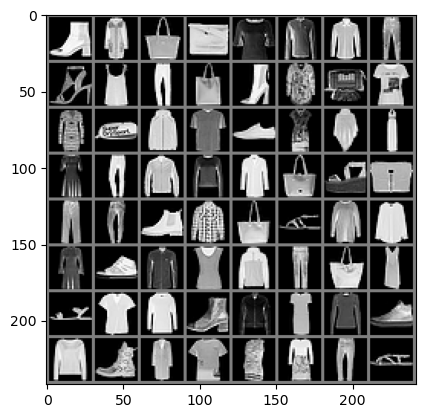

Ankle boot Coat Bag Bag T-shirt/top T-shirt/top Shirt Trouser


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print corresponding labels
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


In [6]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

# Define a basic CNN Model

In [7]:
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the output size after two conv layers and two pool layers on a 28x28 image
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # 64 channels, 7x7 after two pooling operations
        self.fc2 = nn.Linear(512, 10)  # 10 output classes for Fashion-MNIST
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (1, 28, 28) -> (32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 14, 14) -> (64, 7, 7)
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output (64 * 7 * 7)
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BasicCNN().to(device)

model

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [9]:
# Function to evaluate model on validation or test set
def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [10]:
from tqdm import tqdm
# Initialize the network, loss function, and optimizer
net = BasicCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 5
# Training loop with validation
for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()  # Set model to training mode
    running_loss = 0.0
    train_progress = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for i, data in enumerate(train_progress):
        inputs, labels = data
        # print(inputs.shape, labels.shape)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        train_progress.set_postfix(loss=running_loss / (i + 1))

    # After each epoch, evaluate the performance on the validation set
    val_loss, val_accuracy = evaluate(net, valloader, criterion)
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Epoch 1/5, Validation Loss: 0.608, Validation Accuracy: 77.83%


Epoch 2/5, Validation Loss: 0.511, Validation Accuracy: 81.67%


Epoch 3/5, Validation Loss: 0.461, Validation Accuracy: 83.97%


Epoch 4/5, Validation Loss: 0.430, Validation Accuracy: 84.72%


Epoch 5/5, Validation Loss: 0.391, Validation Accuracy: 86.06%
Finished Training


In [13]:
len(testloader)*64

10048

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')


Accuracy of the network on the 10000 test images: 85.36%
